In [ ]:
!pip install -q transformers
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from transformers import *
from torch.nn.functional import cross_entropy, mse_loss
from sklearn.metrics import ndcg_score
from sklearn.metrics import mean_squared_error

from tqdm import tqdm


/opt/conda/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
Discovered apex.normalization.FusedRMSNorm - will use it instead of LongT5LayerNorm
Discovered apex.normalization.FusedRMSNorm - will use it instead of T5LayerNorm


# Preprocessing

In [ ]:
# !unzip dataset.zip

In [ ]:
df = pd.read_json("ranking_train.jsonl", lines=True)

## Разделяем для БЕРТа специальным символом текст и коммент к нему, формат GLUE

In [ ]:
## we need the imput after tokenizer looking like this: [CLS] TEXT [SEP] COMMENT [SEP]
text_comment = []# text with label 4 comment
labels = []
for i in range(len(df)):
  text_comment.append("{} [SEP] {}".format(df['text'][i], df['comments'][i][0]['text']))
  labels.append(0) # super
  text_comment.append("{} [SEP] {}".format(df['text'][i], df['comments'][i][1]['text']))
  labels.append(1) # good
  text_comment.append("{} [SEP] {}".format(df['text'][i], df['comments'][i][2]['text']))
  labels.append(2) # average
  text_comment.append("{} [SEP] {}".format(df['text'][i], df['comments'][i][3]['text']))
  labels.append(3) # poor
  text_comment.append("{} [SEP] {}".format(df['text'][i], df['comments'][i][4]['text']))
  labels.append(4) # bad

In [ ]:
text_comment[10], labels[10]

('How Costco Became the Anti-Wal-Mart [SEP] I really hate it when people falsely claim that the fiduciary responsibilities of a public company includes maximizing profits at every opportunity. Thinking long-term and win-win is the truly responsible CEOs job. Costco is the Google of discount warehouses. Wal-mart is Microsoft.',
 0)

In [ ]:
data = pd.DataFrame(list(zip(text_comment, labels)),
               columns =['text_with_comment', 'label'])
# data = data.sample(frac=0.5).reset_index(drop=True)

## train/test split

In [ ]:
df_train, df_valid = train_test_split(data, test_size = 0.2, random_state=42, stratify=data.label.values)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

# Main classes and methods

## Первый вектор БЕРТа отвечает за классификацию предложений в задаче текстового моделирования image.png, затем мы этот вектор размерности 768 отправляем в полносвязный слой с одним выходным нейроном

In [ ]:
class VK_BERT(DistilBertPreTrainedModel):
    def __init__(self, config):
        config.num_labels = 1
        super(VK_BERT, self).__init__(config)
        self.bert = DistilBertForSequenceClassification(config)
        self.init_weights()

    def forward(self, ids, mask):
        outputs = self.bert(ids, mask)
        logits = outputs[0]
        return logits
        

In [ ]:
class DATALoader:
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # destilbert doesn't have token_type_ids
        self.max_length = 512
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        data = str(self.data[item])
        data = " ".join(data.split())

        inputs = self.tokenizer.encode_plus(data, max_length = self.max_length, pad_to_max_length=True)
        ids = inputs["input_ids"]
        mask = inputs['attention_mask']

        padding_length = self.max_length - len(ids)
        ids = ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.target[item], dtype=torch.long)
        }

In [ ]:
def loss_fn(output, targets):
    # return cross_entropy(output, targets)
    return mse_loss(output, targets) 

In [ ]:
def train_func(data_loader, model, optimizer, device): # can add scheduler
    model.to(device)
    model.train()
    i = 99
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"]
        mask = d["mask"]
        targets = d["targets"]
        
        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        output = model(
            ids=ids,
            mask = mask,
        )
        output = output.squeeze(1)
        
        loss = loss_fn(output, targets)
        if i % 100 == 0:
          print('\n running loss: ', loss)
        i += 1
        loss.backward()
        
        optimizer.step()
        # scheduler.step()

In [ ]:
def eval_func(data_loader, model, device):
    model.eval()
    
    fin_targets = []
    fin_output = []
    
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)


            output = model(
                ids=ids,
                mask = mask,
            )
            output = output.squeeze(1)
        
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_output.extend(torch.sigmoid(output).cpu().detach().numpy().tolist())
            
        return fin_output, fin_targets

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model = VK_BERT.from_pretrained("distilbert-base-uncased")
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}



loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing VK_BERT: ['distilbert.transformer.layer.1.sa_layer_norm.weight', 'distilbert.transformer.layer.1.output_layer_norm.bias', 'distilbert.transformer.layer.1.attention.v_lin.weight', 'distilbert.transformer.layer.3.ffn.lin2.bias', 'distilbert.transformer.layer.2.attention.q_lin.bias', 'distilbert.transformer.layer.2.output_layer_norm.weight', 'distilbert.transformer.layer.4.attention.q_lin.bias', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.1.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.out_lin.bias', 'distilbert.transformer.layer.2.attention.v_lin.bias', 'distilbert.transformer.layer.4.attention.v_

In [ ]:
train_dataset = DATALoader(
        data=df_train.text_with_comment.values,
        target=df_train.label.values,
)

train_data_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=32,
        num_workers=4,
)

val_dataset = DATALoader(
        data=df_valid.text_with_comment.values,
        target=df_valid.label.values,
)

val_data_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=16,
        num_workers=1,
)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_tok

# На train считаем mse, идея кажется хорошей, т.к. не требует отправлять по 5 инпутов, но позволяет понять, насколько близки наши text+comment к лейблам, не привязывая к количеству и конкретным классам. На eval считаем ndcg

In [ ]:
best_score = 0
for epoch in range(2):
    train_func(data_loader=train_data_loader, model=model, optimizer=optimizer, device=device)
    outputs, targets = eval_func(data_loader=train_data_loader, model=model, device=device)
    outputs = np.expand_dims(np.array(outputs), axis=0)
    targets = np.expand_dims(np.array(targets), axis=0)
    ndcg = ndcg_score(targets, outputs)
    print(f"ndcg: {ndcg}")

    if ndcg > best_score:
        best_ndcg = ndcg
        torch.save(model.state_dict(), "best_model.bin")    

  0%|          | 0/11014 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy.


 running loss:  tensor(5.0832, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 101/11014 [00:48<1:27:26,  2.08it/s]


 running loss:  tensor(1.9455, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 201/11014 [01:36<1:26:52,  2.07it/s]


 running loss:  tensor(1.9955, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 301/11014 [02:25<1:26:27,  2.06it/s]


 running loss:  tensor(1.4694, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▎         | 401/11014 [03:13<1:25:35,  2.07it/s]


 running loss:  tensor(1.9570, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▍         | 501/11014 [04:01<1:24:05,  2.08it/s]


 running loss:  tensor(2.0502, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 601/11014 [04:49<1:23:40,  2.07it/s]


 running loss:  tensor(1.4992, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▋         | 701/11014 [05:38<1:22:59,  2.07it/s]


 running loss:  tensor(2.0062, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 801/11014 [06:26<1:22:22,  2.07it/s]


 running loss:  tensor(1.2025, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 901/11014 [07:14<1:21:22,  2.07it/s]


 running loss:  tensor(1.2020, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 1001/11014 [08:03<1:20:35,  2.07it/s]


 running loss:  tensor(2.0855, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 1101/11014 [08:51<1:19:42,  2.07it/s]


 running loss:  tensor(2.1165, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 1201/11014 [09:39<1:18:54,  2.07it/s]


 running loss:  tensor(1.5181, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 1301/11014 [10:28<1:18:14,  2.07it/s]


 running loss:  tensor(1.9481, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 1401/11014 [11:16<1:17:16,  2.07it/s]


 running loss:  tensor(2.1102, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▎        | 1501/11014 [12:04<1:16:14,  2.08it/s]


 running loss:  tensor(1.9922, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 1601/11014 [12:53<1:16:03,  2.06it/s]


 running loss:  tensor(1.3633, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 1701/11014 [13:41<1:15:06,  2.07it/s]


 running loss:  tensor(2.1977, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▋        | 1801/11014 [14:29<1:14:05,  2.07it/s]


 running loss:  tensor(1.2104, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 1901/11014 [15:17<1:13:24,  2.07it/s]


 running loss:  tensor(1.6140, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 2001/11014 [16:06<1:12:47,  2.06it/s]


 running loss:  tensor(1.9272, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 2101/11014 [16:54<1:11:59,  2.06it/s]


 running loss:  tensor(1.8489, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 2201/11014 [17:42<1:10:44,  2.08it/s]


 running loss:  tensor(2.0268, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 2301/11014 [18:31<1:10:10,  2.07it/s]


 running loss:  tensor(2.0132, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 2401/11014 [19:19<1:09:12,  2.07it/s]


 running loss:  tensor(1.3628, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 2501/11014 [20:07<1:08:28,  2.07it/s]


 running loss:  tensor(2.2835, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 2601/11014 [20:56<1:07:51,  2.07it/s]


 running loss:  tensor(1.2126, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 2701/11014 [21:44<1:07:08,  2.06it/s]


 running loss:  tensor(2.0133, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▌       | 2801/11014 [22:32<1:06:02,  2.07it/s]


 running loss:  tensor(2.3289, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▋       | 2901/11014 [23:21<1:05:29,  2.06it/s]


 running loss:  tensor(1.8906, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 3001/11014 [24:09<1:04:14,  2.08it/s]


 running loss:  tensor(2.3468, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 3101/11014 [24:57<1:03:40,  2.07it/s]


 running loss:  tensor(1.9293, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 3201/11014 [25:45<1:02:54,  2.07it/s]


 running loss:  tensor(1.3876, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 3301/11014 [26:34<1:02:10,  2.07it/s]


 running loss:  tensor(1.8405, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 3401/11014 [27:22<1:01:26,  2.07it/s]


 running loss:  tensor(2.1068, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 3501/11014 [28:10<1:00:24,  2.07it/s]


 running loss:  tensor(1.9834, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 3601/11014 [28:59<59:37,  2.07it/s]  


 running loss:  tensor(1.7484, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▎      | 3701/11014 [29:47<58:50,  2.07it/s]


 running loss:  tensor(1.3854, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 3801/11014 [30:35<58:15,  2.06it/s]


 running loss:  tensor(1.6304, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 3901/11014 [31:24<57:17,  2.07it/s]


 running loss:  tensor(2.4183, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 4001/11014 [32:12<56:28,  2.07it/s]


 running loss:  tensor(1.9048, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 4101/11014 [33:00<55:37,  2.07it/s]


 running loss:  tensor(2.0352, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 4201/11014 [33:49<55:00,  2.06it/s]


 running loss:  tensor(2.1884, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 4301/11014 [34:37<54:00,  2.07it/s]


 running loss:  tensor(1.9704, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 4401/11014 [35:25<53:25,  2.06it/s]


 running loss:  tensor(1.4907, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 4501/11014 [36:14<52:37,  2.06it/s]


 running loss:  tensor(1.7176, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 4601/11014 [37:02<51:31,  2.07it/s]


 running loss:  tensor(1.7633, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 4701/11014 [37:50<50:37,  2.08it/s]


 running loss:  tensor(1.2651, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 4801/11014 [38:38<49:57,  2.07it/s]


 running loss:  tensor(1.4869, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 4901/11014 [39:27<49:22,  2.06it/s]


 running loss:  tensor(1.6851, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 5001/11014 [40:15<48:27,  2.07it/s]


 running loss:  tensor(2.0436, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 5101/11014 [41:04<47:42,  2.07it/s]


 running loss:  tensor(1.8831, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 5201/11014 [41:52<46:51,  2.07it/s]


 running loss:  tensor(1.7490, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 5301/11014 [42:40<46:08,  2.06it/s]


 running loss:  tensor(1.3637, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 5401/11014 [43:29<45:20,  2.06it/s]


 running loss:  tensor(1.7093, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 5501/11014 [44:17<44:19,  2.07it/s]


 running loss:  tensor(1.6214, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 5601/11014 [45:05<43:31,  2.07it/s]


 running loss:  tensor(2.5511, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 5701/11014 [45:53<42:48,  2.07it/s]


 running loss:  tensor(1.8967, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 5801/11014 [46:42<41:55,  2.07it/s]


 running loss:  tensor(1.9803, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▎    | 5901/11014 [47:30<41:10,  2.07it/s]


 running loss:  tensor(2.1740, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 6001/11014 [48:18<40:17,  2.07it/s]


 running loss:  tensor(1.9257, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 6101/11014 [49:07<39:43,  2.06it/s]


 running loss:  tensor(2.1093, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 6201/11014 [49:55<38:46,  2.07it/s]


 running loss:  tensor(2.4095, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 6301/11014 [50:43<37:56,  2.07it/s]


 running loss:  tensor(1.8786, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 6401/11014 [51:32<37:12,  2.07it/s]


 running loss:  tensor(1.4219, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 6501/11014 [52:20<36:22,  2.07it/s]


 running loss:  tensor(2.0188, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 6601/11014 [53:09<35:38,  2.06it/s]


 running loss:  tensor(2.0653, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 6701/11014 [53:57<34:50,  2.06it/s]


 running loss:  tensor(2.2460, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 6801/11014 [54:45<33:56,  2.07it/s]


 running loss:  tensor(1.8563, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 6901/11014 [55:34<33:10,  2.07it/s]


 running loss:  tensor(2.1757, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▎   | 7001/11014 [56:22<32:26,  2.06it/s]


 running loss:  tensor(1.8516, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 7101/11014 [57:11<31:31,  2.07it/s]


 running loss:  tensor(1.5060, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 7201/11014 [57:59<30:45,  2.07it/s]


 running loss:  tensor(1.5949, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▋   | 7301/11014 [58:47<29:56,  2.07it/s]


 running loss:  tensor(1.8013, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 7401/11014 [59:36<29:09,  2.06it/s]


 running loss:  tensor(1.7488, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 7501/11014 [1:00:24<28:23,  2.06it/s]


 running loss:  tensor(1.7699, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 7601/11014 [1:01:13<27:28,  2.07it/s]


 running loss:  tensor(2.0077, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 7701/11014 [1:02:01<26:33,  2.08it/s]


 running loss:  tensor(1.7139, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 7801/11014 [1:02:49<25:50,  2.07it/s]


 running loss:  tensor(1.9404, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 7901/11014 [1:03:38<25:06,  2.07it/s]


 running loss:  tensor(1.6900, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 8001/11014 [1:04:26<24:14,  2.07it/s]


 running loss:  tensor(1.6034, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 8101/11014 [1:05:14<23:24,  2.07it/s]


 running loss:  tensor(2.0314, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 8201/11014 [1:06:02<22:35,  2.07it/s]


 running loss:  tensor(2.0631, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▌  | 8301/11014 [1:06:51<21:55,  2.06it/s]


 running loss:  tensor(1.3027, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▋  | 8401/11014 [1:07:39<21:03,  2.07it/s]


 running loss:  tensor(1.7152, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 8501/11014 [1:08:28<20:11,  2.07it/s]


 running loss:  tensor(1.9684, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 8601/11014 [1:09:16<19:21,  2.08it/s]


 running loss:  tensor(1.4895, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 8701/11014 [1:10:04<18:23,  2.10it/s]


 running loss:  tensor(1.7849, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|███████▉  | 8801/11014 [1:10:53<17:52,  2.06it/s]


 running loss:  tensor(1.9643, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 8901/11014 [1:11:41<17:00,  2.07it/s]


 running loss:  tensor(1.3465, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 9001/11014 [1:12:29<16:13,  2.07it/s]


 running loss:  tensor(1.7837, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 9101/11014 [1:13:18<15:27,  2.06it/s]


 running loss:  tensor(1.8542, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▎ | 9201/11014 [1:14:06<14:37,  2.07it/s]


 running loss:  tensor(1.8580, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 9301/11014 [1:14:54<13:48,  2.07it/s]


 running loss:  tensor(1.6430, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 9401/11014 [1:15:43<12:59,  2.07it/s]


 running loss:  tensor(2.0274, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 9501/11014 [1:16:31<12:11,  2.07it/s]


 running loss:  tensor(2.4449, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 9601/11014 [1:17:19<11:22,  2.07it/s]


 running loss:  tensor(1.7702, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 9701/11014 [1:18:08<10:36,  2.06it/s]


 running loss:  tensor(1.6508, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 9801/11014 [1:18:56<09:44,  2.07it/s]


 running loss:  tensor(1.8017, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 9901/11014 [1:19:44<08:58,  2.07it/s]


 running loss:  tensor(1.7894, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 10001/11014 [1:20:33<08:08,  2.07it/s]


 running loss:  tensor(1.9509, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 10101/11014 [1:21:21<07:19,  2.08it/s]


 running loss:  tensor(1.7178, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 10201/11014 [1:22:09<06:31,  2.08it/s]


 running loss:  tensor(1.6705, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▎| 10301/11014 [1:22:57<05:44,  2.07it/s]


 running loss:  tensor(1.3813, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 10401/11014 [1:23:46<04:57,  2.06it/s]


 running loss:  tensor(2.2102, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 10501/11014 [1:24:34<04:08,  2.06it/s]


 running loss:  tensor(1.8396, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▋| 10601/11014 [1:25:23<03:20,  2.06it/s]


 running loss:  tensor(2.5245, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 10701/11014 [1:26:11<02:31,  2.07it/s]


 running loss:  tensor(1.6778, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 10801/11014 [1:26:59<01:43,  2.07it/s]


 running loss:  tensor(1.9160, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 10901/11014 [1:27:48<00:54,  2.07it/s]


 running loss:  tensor(1.8445, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 11001/11014 [1:28:36<00:06,  2.07it/s]


 running loss:  tensor(2.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


  0%|          | 0/11014 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy.

ndcg: 0.9686173710873676


  0%|          | 0/11014 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy.


 running loss:  tensor(1.3940, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 101/11014 [00:49<1:27:50,  2.07it/s]


 running loss:  tensor(1.5872, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 201/11014 [01:37<1:27:12,  2.07it/s]


 running loss:  tensor(1.9847, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 301/11014 [02:25<1:26:17,  2.07it/s]


 running loss:  tensor(1.4283, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▎         | 401/11014 [03:14<1:25:25,  2.07it/s]


 running loss:  tensor(2.1965, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▍         | 501/11014 [04:02<1:24:50,  2.07it/s]


 running loss:  tensor(2.0873, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 601/11014 [04:51<1:23:37,  2.08it/s]


 running loss:  tensor(1.5176, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▋         | 701/11014 [05:39<1:22:54,  2.07it/s]


 running loss:  tensor(1.9662, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 801/11014 [06:27<1:22:06,  2.07it/s]


 running loss:  tensor(1.1852, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 901/11014 [07:15<1:21:08,  2.08it/s]


 running loss:  tensor(1.3509, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 1001/11014 [08:04<1:20:53,  2.06it/s]


 running loss:  tensor(2.0395, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 1101/11014 [08:52<1:19:50,  2.07it/s]


 running loss:  tensor(2.0672, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 1201/11014 [09:40<1:18:55,  2.07it/s]


 running loss:  tensor(1.2714, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 1301/11014 [10:29<1:18:17,  2.07it/s]


 running loss:  tensor(1.8603, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 1401/11014 [11:17<1:17:42,  2.06it/s]


 running loss:  tensor(2.1345, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▎        | 1501/11014 [12:05<1:16:51,  2.06it/s]


 running loss:  tensor(1.9252, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 1601/11014 [12:54<1:15:58,  2.06it/s]


 running loss:  tensor(1.3613, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 1701/11014 [13:42<1:14:59,  2.07it/s]


 running loss:  tensor(1.9098, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▋        | 1801/11014 [14:31<1:14:19,  2.07it/s]


 running loss:  tensor(1.1803, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 1901/11014 [15:19<1:13:40,  2.06it/s]


 running loss:  tensor(1.6847, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 2001/11014 [16:07<1:12:08,  2.08it/s]


 running loss:  tensor(1.8370, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 2101/11014 [16:56<1:11:53,  2.07it/s]


 running loss:  tensor(1.8555, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 2201/11014 [17:44<1:11:10,  2.06it/s]


 running loss:  tensor(1.8896, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 2301/11014 [18:32<1:10:19,  2.07it/s]


 running loss:  tensor(1.8880, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 2401/11014 [19:21<1:09:31,  2.06it/s]


 running loss:  tensor(1.3769, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 2501/11014 [20:09<1:08:52,  2.06it/s]


 running loss:  tensor(2.2602, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 2601/11014 [20:58<1:07:58,  2.06it/s]


 running loss:  tensor(1.2634, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 2701/11014 [21:46<1:06:44,  2.08it/s]


 running loss:  tensor(2.0414, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▌       | 2801/11014 [22:34<1:05:59,  2.07it/s]


 running loss:  tensor(2.0922, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▋       | 2901/11014 [23:23<1:05:36,  2.06it/s]


 running loss:  tensor(1.7313, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 3001/11014 [24:11<1:04:33,  2.07it/s]


 running loss:  tensor(2.3871, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 3101/11014 [24:59<1:03:50,  2.07it/s]


 running loss:  tensor(1.8506, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 3201/11014 [25:48<1:03:13,  2.06it/s]


 running loss:  tensor(1.3628, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 3301/11014 [26:36<1:02:10,  2.07it/s]


 running loss:  tensor(1.7948, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 3401/11014 [27:24<1:01:14,  2.07it/s]


 running loss:  tensor(1.9859, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 3501/11014 [28:13<1:00:29,  2.07it/s]


 running loss:  tensor(2.0132, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 3601/11014 [29:01<59:37,  2.07it/s]  


 running loss:  tensor(1.7024, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▎      | 3701/11014 [29:49<58:53,  2.07it/s]


 running loss:  tensor(1.3453, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 3801/11014 [30:38<58:06,  2.07it/s]


 running loss:  tensor(1.4788, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 3901/11014 [31:26<57:21,  2.07it/s]


 running loss:  tensor(2.3272, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 4001/11014 [32:14<56:37,  2.06it/s]


 running loss:  tensor(1.9740, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 4101/11014 [33:02<55:57,  2.06it/s]


 running loss:  tensor(1.9881, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 4201/11014 [33:51<55:04,  2.06it/s]


 running loss:  tensor(2.1381, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 4301/11014 [34:39<54:09,  2.07it/s]


 running loss:  tensor(1.9045, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 4401/11014 [35:28<53:18,  2.07it/s]


 running loss:  tensor(1.3881, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 4501/11014 [36:16<52:07,  2.08it/s]


 running loss:  tensor(1.6611, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 4601/11014 [37:04<51:48,  2.06it/s]


 running loss:  tensor(1.7388, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 4701/11014 [37:53<50:39,  2.08it/s]


 running loss:  tensor(1.2748, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 4801/11014 [38:41<49:41,  2.08it/s]


 running loss:  tensor(1.4476, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 4901/11014 [39:29<49:39,  2.05it/s]


 running loss:  tensor(1.7164, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 5001/11014 [40:17<48:07,  2.08it/s]


 running loss:  tensor(1.9298, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 5101/11014 [41:05<47:17,  2.08it/s]


 running loss:  tensor(1.7833, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 5201/11014 [41:53<46:29,  2.08it/s]


 running loss:  tensor(1.7477, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 5301/11014 [42:41<45:36,  2.09it/s]


 running loss:  tensor(1.3085, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 5401/11014 [43:29<45:11,  2.07it/s]


 running loss:  tensor(1.6312, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 5501/11014 [44:17<44:04,  2.08it/s]


 running loss:  tensor(1.5954, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 5601/11014 [45:05<43:14,  2.09it/s]


 running loss:  tensor(2.6928, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 5701/11014 [45:53<42:25,  2.09it/s]


 running loss:  tensor(1.7413, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 5801/11014 [46:42<42:12,  2.06it/s]


 running loss:  tensor(2.0129, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▎    | 5901/11014 [47:30<40:52,  2.08it/s]


 running loss:  tensor(2.0232, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 6001/11014 [48:18<40:31,  2.06it/s]


 running loss:  tensor(1.9443, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 6101/11014 [49:06<39:35,  2.07it/s]


 running loss:  tensor(2.1455, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 6201/11014 [49:55<38:46,  2.07it/s]


 running loss:  tensor(2.3566, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 6301/11014 [50:43<37:52,  2.07it/s]


 running loss:  tensor(1.9766, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 6401/11014 [51:31<37:04,  2.07it/s]


 running loss:  tensor(1.4610, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 6501/11014 [52:19<36:18,  2.07it/s]


 running loss:  tensor(1.8753, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 6601/11014 [53:08<35:36,  2.07it/s]


 running loss:  tensor(1.9506, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 6701/11014 [53:56<34:39,  2.07it/s]


 running loss:  tensor(2.2455, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 6801/11014 [54:44<33:55,  2.07it/s]


 running loss:  tensor(1.7793, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 6901/11014 [55:33<33:02,  2.07it/s]


 running loss:  tensor(2.2515, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▎   | 7001/11014 [56:21<32:15,  2.07it/s]


 running loss:  tensor(1.7168, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 7101/11014 [57:09<31:20,  2.08it/s]


 running loss:  tensor(1.4410, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 7201/11014 [57:57<30:38,  2.07it/s]


 running loss:  tensor(1.5857, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▋   | 7301/11014 [58:46<29:49,  2.08it/s]


 running loss:  tensor(1.7045, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 7401/11014 [59:34<29:01,  2.07it/s]


 running loss:  tensor(1.6085, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 7501/11014 [1:00:22<28:18,  2.07it/s]


 running loss:  tensor(1.8877, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 7601/11014 [1:01:11<27:23,  2.08it/s]


 running loss:  tensor(2.0356, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 7701/11014 [1:01:59<26:28,  2.09it/s]


 running loss:  tensor(1.8258, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 7801/11014 [1:02:47<25:55,  2.07it/s]


 running loss:  tensor(1.8965, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 7901/11014 [1:03:35<24:56,  2.08it/s]


 running loss:  tensor(1.6899, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 8001/11014 [1:04:23<24:16,  2.07it/s]


 running loss:  tensor(1.4971, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 8101/11014 [1:05:12<23:24,  2.07it/s]


 running loss:  tensor(2.0289, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 8201/11014 [1:06:00<22:36,  2.07it/s]


 running loss:  tensor(2.0041, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▌  | 8301/11014 [1:06:48<21:48,  2.07it/s]


 running loss:  tensor(1.3010, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▋  | 8401/11014 [1:07:36<21:01,  2.07it/s]


 running loss:  tensor(1.7597, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 8501/11014 [1:08:25<20:09,  2.08it/s]


 running loss:  tensor(1.8835, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 8601/11014 [1:09:13<19:29,  2.06it/s]


 running loss:  tensor(1.4846, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 8701/11014 [1:10:01<18:37,  2.07it/s]


 running loss:  tensor(1.9433, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|███████▉  | 8801/11014 [1:10:49<17:45,  2.08it/s]


 running loss:  tensor(1.9571, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 8901/11014 [1:11:38<16:58,  2.07it/s]


 running loss:  tensor(1.3434, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 9001/11014 [1:12:26<16:13,  2.07it/s]


 running loss:  tensor(1.6567, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 9101/11014 [1:13:14<15:23,  2.07it/s]


 running loss:  tensor(1.7481, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▎ | 9201/11014 [1:14:02<14:37,  2.07it/s]


 running loss:  tensor(1.9357, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 9301/11014 [1:14:51<13:47,  2.07it/s]


 running loss:  tensor(1.5983, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 9401/11014 [1:15:39<12:58,  2.07it/s]


 running loss:  tensor(2.1268, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 9501/11014 [1:16:27<12:13,  2.06it/s]


 running loss:  tensor(2.2485, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 9601/11014 [1:17:16<11:25,  2.06it/s]


 running loss:  tensor(1.8143, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 9701/11014 [1:18:04<10:33,  2.07it/s]


 running loss:  tensor(1.6723, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 9801/11014 [1:18:52<09:44,  2.07it/s]


 running loss:  tensor(1.7591, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 9901/11014 [1:19:40<08:57,  2.07it/s]


 running loss:  tensor(1.8281, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 10001/11014 [1:20:29<08:09,  2.07it/s]


 running loss:  tensor(1.8980, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 10101/11014 [1:21:17<07:25,  2.05it/s]


 running loss:  tensor(1.6881, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 10201/11014 [1:22:06<06:35,  2.06it/s]


 running loss:  tensor(1.5754, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▎| 10301/11014 [1:22:54<05:47,  2.05it/s]


 running loss:  tensor(1.3433, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 10401/11014 [1:23:43<04:58,  2.05it/s]


 running loss:  tensor(2.1663, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 10501/11014 [1:24:32<04:07,  2.07it/s]


 running loss:  tensor(1.9284, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▋| 10601/11014 [1:25:20<03:19,  2.07it/s]


 running loss:  tensor(2.4834, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 10701/11014 [1:26:08<02:31,  2.07it/s]


 running loss:  tensor(1.5974, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 10801/11014 [1:26:56<01:43,  2.06it/s]


 running loss:  tensor(1.8286, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 10901/11014 [1:27:45<00:54,  2.07it/s]


 running loss:  tensor(1.8504, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 11001/11014 [1:28:33<00:06,  2.07it/s]


 running loss:  tensor(2.0695, device='cuda:0', grad_fn=<MseLossBackward0>)


  0%|          | 0/11014 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy.

In [ ]:
best_ndcg

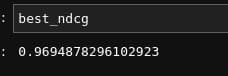

In [ ]:
df = pd.read_json("ranking_test.jsonl", lines=True) 
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


# Делаем inference на тестовом файле и сохраняем

In [ ]:
com = []
#1*5 + 4
for i in range(len(df)):
  com.append("{} [SEP] {}".format(df['text'][i], df['comments'][i][0]['text']))
  com.append("{} [SEP] {}".format(df['text'][i], df['comments'][i][1]['text']))
  com.append("{} [SEP] {}".format(df['text'][i], df['comments'][i][2]['text']))
  com.append("{} [SEP] {}".format(df['text'][i], df['comments'][i][3]['text']))
  com.append("{} [SEP] {}".format(df['text'][i], df['comments'][i][4]['text']))

In [ ]:
model.eval()
com_out = []
for i in tqdm(range(len(df))):
  com_out = []
  for j in range(5):
    com_encoded = tokenizer.encode_plus(com[i*5 + j], max_length = 512, pad_to_max_length=True, return_tensors="pt") # .encode_plus(data, max_length = self.max_length, pad_to_max_length=True)
    ids = com_encoded["input_ids"]
    mask = com_encoded["attention_mask"]
    ids = ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    output = model(ids, mask).squeeze(1)
    com_out.extend(torch.sigmoid(output).cpu().detach().numpy().tolist())
  order = (np.argsort(com_out)) 

  for score, idx in enumerate(np.argsort(com_out)):
    df['comments'][i][idx]['score'] = score

In [ ]:
output_path = "results/ranking_test.jsonl"

In [ ]:
with open(output_path, "w") as f:
    f.write(df.to_json(orient='records', lines=True))